### Load the LLM
##### Instantiate the Language Model (LLM) with Gemini 2.0 Flash
 - temperature: Controls creativity (0 = deterministic, 1 = more random)
 - max_tokens: Limits the length of the response

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.7,
    max_tokens=256,
)

### Define State
TypedDict helps define a dictionary structure where specific keys have specific types
Annotated is used to attach metadata to a type, here it's used to specify special behavior for the 'messages' list
- list is the expected type (list of messages)
- add_messages is a helper from LangGraph that tells the graph how to accumulate message history over time


In [3]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

### Define chatbot node
- The chatbot function takes in the current state (which contains the conversation history),
- and returns an updated state with the new AI response appended.

In [33]:
def chatbot(state: State) -> State:
    return{"messages": [llm.invoke(state["messages"])]}

### Build and compile graph

In [5]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)

builder.add_edge(START, "chatbot_node")
builder.add_edge("chatbot_node", END)

graph = builder.compile()

### Visualize the Graph
- Visualize the structure of your graph in Jupyter environments

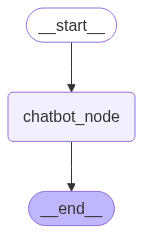

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Test the graph with a single message

In [34]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

message = {"role": "user", "content": "Who walked on the moon for the first time? Print only the name"}
# message = {"role": "user", "content": "What is langchain?"}
response = graph.invoke({"messages":[message]})


# Print both user and AI messages clearly
for msg in response["messages"]:
    if isinstance(msg, HumanMessage):
        print(f"👤 Human: {msg.content}")
    elif isinstance(msg, AIMessage):
            print(f"🤖 AI: {msg.content}")

👤 Human: Who walked on the moon for the first time? Print only the name
🤖 AI: Neil Armstrong


### Loop-Based Interactive Chat (Memory Persisted)
- Since this is a StateGraph, a state object has to be created 

In [31]:
state = State({"messages": [{"role": "user", "content": "You are a hellpful assistant"}]})

while True:
    in_message = input("You: ")
    if in_message.lower() in {"quit","exit"}:
        break
    state["messages"].append({"role": "user", "content": in_message})

    state = graph.invoke(state)
    print("👤 You:", in_message)
    print("🤖 Bot:", state["messages"][-1].content)

👤 You: Hi, I'm Anupesh and I'm a Data Engineer.
🤖 Bot: Hi Anupesh! It's nice to meet you. Data Engineering is a fascinating and crucial field. What are you working on these days? I'm always interested in learning about the different projects and challenges Data Engineers face. Perhaps you're building data pipelines, working with cloud technologies, or optimizing data storage?

Let me know if you have any questions for me, or if there's anything I can help you with!
👤 You: Tell me my and my designation.
🤖 Bot: Okay, I understand. Based on our conversation, you are **Anupesh, a Data Engineer.**


### Another way of initializing chatbot

In [32]:
state = None

while True:
    in_message = input("You: ")
    if in_message.lower() in {"quit","exit"}:
        break
    if state is None:
        state: State = {
            "messages": [{"role": "user", "content": in_message}]
        }
    else:
        state["messages"].append({"role": "user", "content": in_message})

    state = graph.invoke(state)
    print("You:", in_message)
    print("Bot:", state["messages"][-1].content)

You: Hi, I'm Anupesh and I'm a data engineer
Bot: Hi Anupesh! Nice to meet you. It's great to connect with another data professional. Is there anything I can help you with today? Perhaps you have a question about data engineering, want to brainstorm a problem, or just want to chat about the field? Let me know!
You: Tell me about me and my designation.
Bot: Alright, Anupesh, let's talk about you and your designation as a Data Engineer. Based on that information, here's what I can tell you:

**About Anupesh:**

*   **Your Name:** Anupesh
*   **Profession:** Data Engineer

**About a Data Engineer:**

Data Engineers are the architects and builders of the data ecosystem within an organization. They are responsible for designing, building, and maintaining the infrastructure that enables data to be collected, stored, processed, and made available for analysis and decision-making.

Here's a more detailed breakdown of the role:

*   **Core Responsibilities:**

    *   **Data Pipeline Developmen